In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse
from tqdm import tqdm

from recommender.testing.custom_metric_utils import create_recommendations_profiles_embeddings, calculate_metric_scores
from recommender.tools.lightfm_utils import LightFMTests

THREADS = 8

## Data loading

In [13]:
DATA_ROOT='../../data'

model = pd.read_pickle('../notebooks_data/custom_model.pkl')

In [14]:
dataset = pd.read_pickle(f'{DATA_ROOT}/dataset.pkl')
item_features = pd.read_pickle(f'{DATA_ROOT}/item_features.pkl')
train_interactions = scipy.sparse.load_npz(f'{DATA_ROOT}/train_interactions.npz')
full_test_interactions = scipy.sparse.load_npz(f'{DATA_ROOT}/test_interactions.npz')

In [15]:
full_df = pd.read_csv(f'{DATA_ROOT}/ratings_all_implicit.csv.gz')
train_df = pd.read_csv(f'{DATA_ROOT}/ratings_train_implicit.csv.gz')
test_df = pd.read_csv(f'{DATA_ROOT}/ratings_test_implicit.csv.gz')
games_df = pd.read_json(f'{DATA_ROOT}/bgg_GameItem.jl', lines=True)[[
    'name', 'bgg_id', 'mechanic', 'category', 'complexity',
    'max_players_best', 'min_players_best', 'max_players_rec', 'min_players_rec'
]]

features_names = pd.read_csv(f'{DATA_ROOT}/game_features_names.csv.gz').values.flatten()
game_features = pd.read_csv(f'{DATA_ROOT}/game_features.csv.gz')

In [16]:
users_profiles = pd.read_pickle(f'{DATA_ROOT}/users_profiles.pkl')
test_users_profiles = pd.read_pickle(f'{DATA_ROOT}/test_users_profiles.pkl')
games_profiles = pd.read_pickle(f'{DATA_ROOT}/games_profiles.pkl')

In [17]:
users_profiles.index = users_profiles.index.map(dataset.mapping()[0])
test_users_profiles.index = test_users_profiles.index.map(dataset.mapping()[0])
games_profiles.index = games_profiles.index.map(dataset.mapping()[2])
users_profiles = users_profiles.sort_index()
test_users_profiles = test_users_profiles.sort_index()
games_profiles = games_profiles.sort_index()

In [18]:
users_profiles.values[:, :40] *= 3
test_users_profiles.values[:, :40] *= 3

In [19]:
mechanics_names = features_names[:20]
categories_names = features_names[20:40]

## Users activity

In [20]:
train_counts = train_df['bgg_user_name'].value_counts().rename('train')
test_counts = test_df['bgg_user_name'].value_counts().rename('test')

users_df = pd.concat((train_counts, test_counts), axis=1).dropna()

(array([10128., 24252., 17810.,  8763.,  4989.,  7357.,  1985.,   663.,
          285.,   289.]),
 array([   1,   10,   25,   50,   75,  100,  200,  300,  400,  500, 1000]),
 <BarContainer object of 10 artists>)

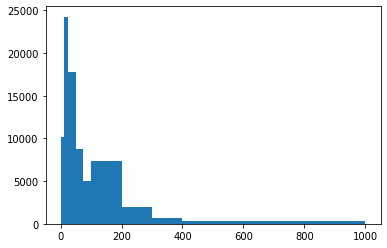

In [21]:
plt.hist(users_df['train'], bins=[1, 10, 25, 50, 75, 100, 200, 300, 400, 500, 1000])

## Utils

In [24]:
def evaluate(min_train, max_train, min_test, max_test):
    users = users_df[(users_df['train'] > min_train)
                     & (users_df['train'] < max_train)
                     & (users_df['test'] > min_test)
                     & (users_df['test'] < max_test)].index.values
    print("Number of chosen users: ", len(users))
    chosen_ratings = test_df[test_df['bgg_user_name'].isin(users)]
    print("Number of ratings of chosen users: ", len(chosen_ratings))
    test_interactions = dataset.build_interactions(
        (
            (val["bgg_user_name"], val["bgg_id"], val["value"])
            for idx, val in chosen_ratings.iterrows()
        )
    )[1]
    print("Test interactions prepared")
    test_class = LightFMTests(model=model,
                              train_df=train_df,
                              dataset=dataset,
                              train_interactions=train_interactions,
                              test_interactions=test_interactions,
                              item_features=item_features)
    precision = test_class.precision_at_k(k=5,
                                          num_threads=THREADS).mean()
    print("Precision calculated: ", precision)
    users_names = np.random.choice(users, size=len(users), replace=False)
    users_id = pd.Series(users_names).map(dataset.mapping()[0]).values
    users_id.sort()
    num_recs = 5
    recommendation_profiles = create_recommendations_profiles_embeddings(
        test_class.get_top_n(num_recs, users_id), num_recs, games_df, categories_names, mechanics_names, 10
    )
    recommendation_profiles.index = recommendation_profiles.index.map(dataset.mapping()[0])
    recommendation_profiles = recommendation_profiles.sort_index()
    score = calculate_metric_scores(recommendation_profiles, test_users_profiles.loc[users_id])
    print("Custom metric score calculated: ", score)
    return precision, score, len(users)

## Results

In [25]:
precision_scores = []
custom_metric_scores = []
users_count = []
buckets = [(0, 15), (15, 25), (25, 50), (50, 100), (100, 250), (250, 500), (500, np.inf),
           (10, 100), (100, 500), (0, np.inf)]
for min_train, max_train in tqdm(buckets):
    precision_score, custom_metric_score, users = evaluate(min_train=min_train,
                                                    max_train=max_train,
                                                    min_test=4,
                                                    max_test=np.inf)
    precision_scores.append(precision_score)
    custom_metric_scores.append(custom_metric_score)
    users_count.append(users)

  0%|          | 0/10 [00:00<?, ?it/s]

Number of chosen users:  8387
Number of ratings of chosen users:  44440
Test interactions prepared
Precision calculated:  0.0077023963


 10%|█         | 1/10 [01:05<09:48, 65.43s/it]

Custom metric score calculated:  [1.60436567 1.48358487 0.71664944 0.73886294 4.54346291]
Number of chosen users:  11874
Number of ratings of chosen users:  101761
Test interactions prepared
Precision calculated:  0.00889338


 20%|██        | 2/10 [02:40<11:02, 82.83s/it]

Custom metric score calculated:  [1.5362098  1.46902123 0.70672902 0.75538809 4.46734815]
Number of chosen users:  17057
Number of ratings of chosen users:  263166
Test interactions prepared
Precision calculated:  0.01002521


 30%|███       | 3/10 [05:09<13:11, 113.05s/it]

Custom metric score calculated:  [1.47209292 1.45767156 0.69665008 0.77389435 4.40030892]
Number of chosen users:  13102
Number of ratings of chosen users:  398159
Test interactions prepared
Precision calculated:  0.013768891


 40%|████      | 4/10 [07:22<12:04, 120.81s/it]

Custom metric score calculated:  [1.42158669 1.4487394  0.68973872 0.79094616 4.35101097]
Number of chosen users:  8515
Number of ratings of chosen users:  549280
Test interactions prepared
Precision calculated:  0.022618907


 50%|█████     | 5/10 [09:18<09:55, 119.17s/it]

Custom metric score calculated:  [1.3752814  1.43449398 0.67915256 0.80585793 4.29478587]
Number of chosen users:  1656
Number of ratings of chosen users:  233136
Test interactions prepared
Precision calculated:  0.03804348


 60%|██████    | 6/10 [09:57<06:07, 91.82s/it] 

Custom metric score calculated:  [1.32856608 1.41139575 0.66944545 0.8279827  4.23738998]
Number of chosen users:  307
Number of ratings of chosen users:  89822
Test interactions prepared
Precision calculated:  0.07557003


 70%|███████   | 7/10 [10:15<03:23, 67.87s/it]

Custom metric score calculated:  [1.28190738 1.405193   0.65597035 0.8413669  4.18443763]
Number of chosen users:  52706
Number of ratings of chosen users:  837774
Test interactions prepared
Precision calculated:  0.010279666


 80%|████████  | 8/10 [17:48<06:20, 190.42s/it]

Custom metric score calculated:  [1.49581522 1.46204086 0.70060651 0.76819205 4.42665464]
Number of chosen users:  10185
Number of ratings of chosen users:  783914
Test interactions prepared
Precision calculated:  0.02509573


 90%|█████████ | 9/10 [20:20<02:58, 178.35s/it]

Custom metric score calculated:  [1.36759431 1.43066446 0.67756444 0.80948506 4.28530826]
Number of chosen users:  64832
Number of ratings of chosen users:  1724508
Test interactions prepared
Precision calculated:  0.0128917815


100%|██████████| 10/10 [30:39<00:00, 183.97s/it]

Custom metric score calculated:  [1.47755611 1.4573342  0.69715176 0.77435706 4.40639914]


In [26]:
results = [{"min_train": train_count[0],
            "max_train": train_count[1],
            "num_users": users,
            "precision": precision,
            "custom_metric_score": metric_score[4],
            "categories_score": metric_score[0],
            "mechanics_score": metric_score[1],
            "players_count_score": metric_score[2],
            "complexity_score": metric_score[3]
           } for train_count, precision, metric_score, users in zip(buckets, precision_scores, custom_metric_scores, users_count)
          ]

In [27]:
pd.DataFrame(results)

,min_train,max_train,num_users,precision,custom_metric_score,categories_score,mechanics_score,players_count_score,complexity_score
0,0,15.0,8387,0.007702,4.543463,1.604366,1.483585,0.716649,0.738863
1,15,25.0,11874,0.008893,4.467348,1.536210,1.469021,0.706729,0.755388
2,25,50.0,17057,0.010025,4.400309,1.472093,1.457672,0.696650,0.773894
3,50,100.0,13102,0.013769,4.351011,1.421587,1.448739,0.689739,0.790946
4,100,250.0,8515,0.022619,4.294786,1.375281,1.434494,0.679153,0.805858
5,250,500.0,1656,0.038043,4.237390,1.328566,1.411396,0.669445,0.827983
6,500,inf,307,0.075570,4.184438,1.281907,1.405193,0.655970,0.841367
7,10,100.0,52706,0.010280,4.426655,1.495815,1.462041,0.700607,0.768192
8,100,500.0,10185,0.025096,4.285308,1.367594,1.430664,0.677564,0.809485
9,0,inf,64832,0.012892,4.406399,1.477556,1.457334,0.697152,0.774357
